## Script info

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""   Analyse simulations   -- Version 1.0
Last edit:  2023/08/29
Authors:    Leone, Riccardo (RL)
Notes:      - Analyse all the models
            - Release notes:
                * Initial commit
To do:      - 
Comments:   

Sources: 
"""

'   Analyse simulations   -- Version 1.0\nLast edit:  2023/08/29\nAuthors:    Leone, Riccardo (RL)\nNotes:      - Analyse all the models\n            - Release notes:\n                * Initial commit\nTo do:      - \nComments:   \n\nSources: \n'

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from petTOAD_setup import *
from statannotations.Annotator import Annotator

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


## Directories

In [3]:
SIM_DIR = RES_DIR / "final_simulations"
A_DIR = SIM_DIR / "a-weight_ws_-0.1-0.1_bs_-0.05-0.05"
A_RAND_DIR = SIM_DIR / "a-weight_ws_-0.1-0.1_bs_-0.05-0.05_random"
G_DIR = SIM_DIR / "G-weight_ws_-1.0-1.0_bs_-0.5-0.5"
G_RAND_DIR = SIM_DIR / "G-weight_ws_-1.0-1.0_bs_-0.5-0.5_random"
SC_DIR = SIM_DIR / "sc_disconn"
HET_DIR = SIM_DIR / "heterogeneous_ws_-0.1-0.1_bs_-0.05-0.05"
HET_RAND_DIR = SIM_DIR / "heterogeneous_ws_-0.1-0.1_bs_-0.05-0.05_random"
FIG_DIR = SIM_DIR / "Figures"
if not Path.exists(FIG_DIR):
    Path.mkdir(FIG_DIR)
MCI_DIR = RES_DIR / "model_simulations" / "MCI_noWMH"

## Functions

In [4]:
def annotate_star(tbl):
    """
    This function is just to plot a start at the best heatmap value for better recognition
    """
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): "*"})
    return star

def find_max_b_w_tbl(tbl):
    """
    This function finds the w and b that are associated with the star (best value) in the heatmap of group comparisons
    """
    max_value = tbl.values.max()
    mask = tbl == max_value
    column_names = tbl.columns[mask.any(axis=0)]
    column_floats = [float(col) for col in column_names]
    row_names = tbl.index[mask.any(axis=1)]
    row_floats = [float(row) for row in row_names]
    return row_floats[0], column_floats[0]

def get_best_dfs(big_df, fc_name, phfcd_name):
    # Get the best model fits for fc, phfcd for each subject and create one single df (skip fcd for now)
    res_df_best = pd.DataFrame(
        {
            fc_name: big_df.groupby(["PTID"])[fc_name].max(),
            phfcd_name: big_df.groupby(["PTID"])[phfcd_name].max(),
        }
    ).reset_index()

    res_df_best["wmh_load"] = [wmh_dict[subj] for subj in res_df_best["PTID"]]
    # This df is to check what are the best w, b in case of the best fc and best phfcd
    # First we group by each patient and get the max fc pearson for each
    # Then we merge this df (with the name of pt and max fc) with the df containing also b and w
    # so we have: max(FC), b, w for each patient
    max_fc_vals = big_df.groupby(["PTID"])[fc_name].max().reset_index()
    merged_df_max_fc = pd.merge(big_df, max_fc_vals, on=["PTID", fc_name])
    # We do the same for 1-phFCD
    max_phfcd_vals = big_df.groupby(["PTID"])[phfcd_name].max().reset_index()
    merged_df_max_phfcd = pd.merge(big_df, max_phfcd_vals, on=["PTID", phfcd_name])

    return merged_df_max_fc, merged_df_max_phfcd


def plot_parm_best_wmh_relationship(parm):
    """
    This function plots the relationship between the best achieved FC and (1-phFCD) and WMH (normalized) in the parameter space that was explored
    """
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    # Values that give the best FC
    sns.regplot(
        ax=axs[0, 0], data=df_max_fc_a, x="wmh_load", y=parm, color="green", label="All"
    )

    sns.regplot(
        ax=axs[0, 1],
        data=df_max_fc_a[df_max_fc_a["PTID"].isin(CN_WMH)],
        x="wmh_load",
        y=parm,
        label="CN WMH",
    )
    sns.regplot(
        ax=axs[0, 1],
        data=df_max_fc_a[df_max_fc_a["PTID"].isin(MCI_WMH)],
        x="wmh_load",
        y=parm,
        label="MCI WMH",
    )
    axs[0, 0].set_ylabel(f"{parm} (best FC)")
    axs[0, 1].set_ylabel(f"{parm} (best FC)")

    # Values that give the best phFCD
    sns.regplot(ax=axs[1, 0], data=df_max_phfcd_a, x="wmh_load", y=parm, color="green")
    sns.regplot(
        ax=axs[1, 1],
        data=df_max_phfcd_a[df_max_phfcd_a["PTID"].isin(CN_WMH)],
        x="wmh_load",
        y=parm,
    )
    sns.regplot(
        ax=axs[1, 1],
        data=df_max_phfcd_a[df_max_phfcd_a["PTID"].isin(MCI_WMH)],
        x="wmh_load",
        y=parm,
    )
    axs[1, 0].set_ylabel(f"{parm} (best phFCD)")
    axs[1, 1].set_ylabel(f"{parm} (best phFCD)")

    fig.legend()
    fig.tight_layout()

def create_pivot_tables(df_res):
    # Convert the result df into a pivot table so to plot heatmap
    table_fc = pd.pivot_table(
        df_res, values="fc_pearson", index="b", columns="w"
    ).astype(float)
    # Skip fcd for now
    # table_fcd = pd.pivot_table(res_df, values='fcd_ks', index='b', columns='w').astype(float)
    table_phfcd = pd.pivot_table(
        df_res, values="phfcd_ks", index="b", columns="w"
    ).astype(float)
    # Create a composite score by summing up the single model fits so to choose when FC and phFCD have different "best" b-w combinations
    table_comp_score = table_fc + 2*table_phfcd
    return table_fc, table_phfcd, table_comp_score

def plot_save_heatmaps(table_fc, table_phfcd, table_comp_score, group, random):
    """
    This function starts from the results dataframe, converts it into a pivot-table, which is what seaborn need to plot the heatmap.
    It does so both for fc and for phfcd. Also plots and saves the results.
    """
    # Create Heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ax=axs[0],
        data=table_fc,
        annot=annotate_star(table_fc),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[0].set_title(f"FC", fontsize=9)

    sns.heatmap(
        ax=axs[1],
        data=table_phfcd,
        annot=annotate_star(table_phfcd),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[1].set_title(f"1 - phFCD", fontsize=9)
    sns.heatmap(
        ax=axs[2],
        data=table_comp_score,
        annot=annotate_star(table_comp_score),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[2].set_title(f"FC + 1*(1 - phFCD)", fontsize=9)
    if not random:
        savename = f"{group}_results_heatmap.png"
        fig.suptitle(f"{group} Random = False")
    else:
        savename = f"{group}_results_heatmap_random.png"
        fig.suptitle(f"{group} Random = True")
    fig.tight_layout()
    plt.savefig(FIG_DIR / savename)


def perform_group_analyses(adnimerge, big_df, group, random):
    """
    This function allow us to select the grouping classification (Fazekas 1, Fazekas 2 or all) as the 'group'variable and then it selects
    only CN and MCI with WMH based on the chosen classification (since we are not interested for this type of model in patients without WMH).
    Then, calls the save_plot_results function, which plots and saves a summary heatmap of the mean FC and 1-phFCD across all patients that fall
    into a category (CN or MCI) according to the chosen grouping.

    Args:
        adnimerge:
        big_df:
        group:
        random:

    Returns:
        The b and ws associated with 
    """
    if group == "Group_bin":
        # This is a convenience way to not to have to rewrite the whole function...
        # Of course, in this specific case, even if the variables are called CN_WMH and MCI_WMH, we are dealing with the whole group
        CN_WMH = adnimerge[adnimerge[group] == "CN"]["PTID"]
        MCI_WMH = adnimerge[adnimerge[group] == "MCI"]["PTID"]
    else:
        CN_WMH = adnimerge[adnimerge[group] == "CN_WMH"]["PTID"]
        MCI_WMH = adnimerge[adnimerge[group] == "MCI_WMH"]["PTID"]

    # CN_no_WMH = adnimerge[adnimerge[group] == 'CN_no_WMH']['PTID']
    # CN_no_wmh_df = big_df[big_df['PTID'].isin(CN_no_WMH)]
    # CN_no_wmh_grouped = CN_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    # save_plot_results(CN_no_wmh_grouped, "CN_no_wmh_Fazekas_1.0")

    CN_wmh_df = big_df[big_df["PTID"].isin(CN_WMH)]
    CN_wmh_grouped = CN_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    tbl_fc_CN_wmh, tbl_phfcd_CN_wmh, tbl_comp_score_CN_wmh =  create_pivot_tables(CN_wmh_grouped)
    plot_save_heatmaps( tbl_fc_CN_wmh, tbl_phfcd_CN_wmh, tbl_comp_score_CN_wmh, f"CN_wmh_{group}", random)

    # MCI_no_WMH = adnimerge[adnimerge[group] == 'MCI_no_WMH']['PTID']
    # mci_no_wmh_df = big_df[big_df['PTID'].isin(MCI_no_WMH)]
    # mci_no_wmh_grouped = mci_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    # save_plot_results(mci_no_wmh_grouped, "mci_no_wmh_Fazekas_1.0")

    mci_wmh_df = big_df[big_df["PTID"].isin(MCI_WMH)]
    mci_wmh_grouped = mci_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    tbl_fc_mci_wmh, tbl_phfcd_mci_wmh, tbl_comp_score_mci_wmh =  create_pivot_tables(mci_wmh_grouped)
    plot_save_heatmaps(tbl_fc_mci_wmh, tbl_phfcd_mci_wmh, tbl_comp_score_mci_wmh, f"mci_wmh_{group}", random)

    b_CN_wmh, w_CN_wmh = find_max_b_w_tbl(tbl_comp_score_CN_wmh)
    b_mci_wmh, w_mci_wmh = find_max_b_w_tbl(tbl_comp_score_mci_wmh)

    print("The best parameters found for these heatmaps are:")
    print(f"b = {b_CN_wmh}, w = {w_CN_wmh}, for CN with WMH")
    print(f"b = {b_mci_wmh}, w = {w_mci_wmh}, for MCI with WMH")

    return b_CN_wmh, w_CN_wmh, b_mci_wmh, w_mci_wmh

def plot_compare_grouping(joined_compare_df, order, title, savename):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    sns.boxplot(
        ax=axs[0],
        data=joined_compare_df,
        x="values",
        y="fc_pearson",
        hue="group",
        order=order,
    )
    axs[0].set_ylabel("PCC")
    sns.boxplot(
        ax=axs[1],
        data=joined_compare_df,
        x="values",
        y="phfcd_ks",
        hue="group",
        order=order,
    )
    axs[1].set_ylabel("1 - KS")
    sns.boxplot(
        ax=axs[2],
        data=joined_compare_df,
        x="values",
        y="summed_fc_phfcd",
        hue="group",
        order=order,
    )
    axs[2].set_ylabel("PCC + (1 - KS)")
    fig.suptitle(title)
    plt.savefig(FIG_DIR / savename)
    plt.show()
    fig.tight_layout()


def select_b_w_combo(df_boxplot_long, w1, b1, w2, b2, groupname1, groupname2):
    compare_df1 = df_boxplot_long[
        (df_boxplot_long["w"] == w1) & (df_boxplot_long["b"] == b1)
    ]
    compare_df1 = compare_df1[compare_df1["group"] == groupname1]
    compare_df2 = df_boxplot_long[
        (df_boxplot_long["w"] == w2) & (df_boxplot_long["b"] == b2)
    ]
    compare_df2 = compare_df2[compare_df2["group"] == groupname2]
    joined_compare_df = pd.concat([compare_df1, compare_df2])
    return compare_df1, compare_df2, joined_compare_df

def create_df_boxplot(df_big,
                      best_fit_b,
                      best_fit_w,
                      diagnosis_group_wmh,
                      model_type):

    """
    This function starts from the big database obtained from the model simulation (e.g., a-weighted homogenous, G-weighted homgoeneous, heterogeneous, etc.) and creates
    a smaller dataset with only the observable variables obtained with the best b and w combination as before. It is useful to then create a long df for plotting.
    """
    df = pd.DataFrame()
    df["PTID"] = df_big[(df_big["b"] == best_fit_b) & (df_big["w"] == best_fit_w) & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["PTID"]
    df["fc_pearson"] = df_big[(df_big["b"] == best_fit_b) & (df_big["w"] == best_fit_w) & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["fc_pearson"]
    df["phfcd_ks"] = df_big[(df_big["b"] == best_fit_b) & (df_big["w"] == best_fit_w) & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["phfcd_ks"]
    df["comp_score"] = df["fc_pearson"] + 2*df["phfcd_ks"]
    df["Model_type"] = [f"{model_type}" for _ in range(len(df))]
    return df

def plot_obs(df, obs):
    """
    This function plots the annotations for statistical comparisons between groups
    """
    order = ["Base", "Homo.", "Hetero.", "G-weight", "Disconn."]
    # Choose the combinations that you want to test..
    pairs=[("Base", "Homo."),
           ("Base", "Hetero."),
           ("Base", "G-weight"),
           ("Base", "Disconn.")]
    ax = sns.boxplot(data = df, x = "Model_type", y = obs)
    annotator = Annotator(ax, pairs, data=df, x="Model_type", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside', verbose = 1)
    annotator.apply_and_annotate()
    plt.xticks([0, 1, 2, 3, 4], order)
    plt.xlabel("Model type")

def plot_random_comparison(df, obs, axs):
    """
    This function is for plotting the comparison between the model results achieved in CN and MCI with the same model"""
    pairs = [
        (("Homo.", "Random"), ("Homo.", "Not Random")),
        (("Hetero.", "Random"), ("Hetero.", "Not Random")),
        (("G-weight", "Random"), ("G-weight", "Not Random")),
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        'plot_params': { # this takes what normally goes into sns.barplot etc.
            'x': 'Model_type',
            'y': f'{obs}',
            'hue': 'Random',
            'hue_order': ["Random","Not Random"]
        },
        'annotation_func': 'apply_test', 
        'configuration': {'test': 'Wilcoxon'}, # this takes what normally goes into ant.configure
        'plot': 'boxplot',
        # If you want to add the figure into a subplot...
        'ax': axs
    }

    df["Model_type"] = df["Model_type"].str.replace("Homo. rand.", "Homo.")
    df["Model_type"] = df["Model_type"].str.replace("Hetero. rand.", "Hetero.")
    df["Model_type"] = df["Model_type"].str.replace("G rand.", "G-weight")


    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df, aspect = 1.5, height = 4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which 
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    plt.close()

def plot_CN_mci_comparison(obs, axs):
    """
    This function is for plotting the comparison between the model results achieved in CN and MCI with the same model"""
    pairs = [
        (("Base", "CN WMH"), ("Base", "MCI WMH")),
        (("Homo.", "CN WMH"), ("Homo.", "MCI WMH")),
        (("Hetero.", "CN WMH"), ("Hetero.", "MCI WMH")),
        (("G-weight", "CN WMH"), ("G-weight", "MCI WMH")),
        (("Disconn.", "CN WMH"), ("Disconn.", "MCI WMH")),
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        'plot_params': { # this takes what normally goes into sns.barplot etc.
            'x': 'Model_type',
            'y': f'{obs}',
            'hue': 'group',
            'hue_order': ["CN WMH","MCI WMH"]
        },
        'annotation_func': 'apply_test', 
        'configuration': {'test': 'Mann-Whitney'}, # this takes what normally goes into ant.configure
        'plot': 'boxplot',
        # If you want to add the figure into a subplot...
        'ax': axs
    }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df_boxplot_compare, aspect = 1.5, height = 4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which 
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    plt.close()



## Prepare data

In [5]:
# Load wmh dictionary
wmh_dict = get_wmh_load_homogeneous(subjs_to_sim)
# Create overall dfs for each model and populate them with single subject results
df_a_big = pd.DataFrame()
df_a_rand_big = pd.DataFrame()
df_sc_big = pd.DataFrame()
df_G_big = pd.DataFrame()
df_G_rand_big = pd.DataFrame()
df_het_big = pd.DataFrame()
df_het_rand_big = pd.DataFrame()

# We loop through every subject
for subj in subjs_to_sim:
    # we read the csv of saved results for each subject for all models
    df_a = pd.read_csv(
        A_DIR / f"sub-{subj}_df_results_homogeneous_a-weight.csv", index_col=0
    )
    df_a_rand = pd.read_csv(
        A_RAND_DIR / f"sub-{subj}_df_results_homogeneous_a-weight.csv",
        index_col=0,
    )
    df_het = pd.read_csv(
        HET_DIR / f"sub-{subj}_df_results_heterogeneous.csv",
        index_col=0,
        )
    df_het_rand = pd.read_csv(
        HET_RAND_DIR / f"sub-{subj}_df_results_heterogeneous.csv",
        index_col=0,
        )
    df_G = pd.read_csv(
        G_DIR / f"sub-{subj}_df_results_homogeneous_G-weight.csv", index_col=0
    )
    df_G_rand = pd.read_csv(
        G_RAND_DIR / f"sub-{subj}_df_results_homogeneous_G-weight.csv", index_col=0
    )
    df_sc = pd.read_csv(
        SC_DIR / f"sub-{subj}_df_results_disconn.csv", index_col=0
    )

    
    # Set the PTID column == to this subject
    df_a["PTID"] = subj
    df_a_rand["PTID"] = subj
    df_het["PTID"] = subj
    df_het_rand["PTID"] = subj
    df_G["PTID"] = subj
    df_G_rand["PTID"] = subj
    df_sc["PTID"] = subj

    # Get the wmh load for this subject
    df_a["wmh_load"] = wmh_dict[subj]
    df_G["wmh_load"] = wmh_dict[subj]
    
    # we concatenate results of all subjects and create model-specific datasets with all patients
    df_a_big = pd.concat([df_a_big, df_a], ignore_index=True)
    df_a_rand_big = pd.concat([df_a_rand_big, df_a_rand], ignore_index=True)
    df_het_big = pd.concat([df_het_big, df_het], ignore_index=True)
    df_het_rand_big = pd.concat([df_het_rand_big, df_het_rand], ignore_index=True)
    df_G_big = pd.concat([df_G_big, df_G], ignore_index=True)
    df_G_rand_big = pd.concat([df_G_rand_big, df_G_rand], ignore_index=True)
    df_sc_big = pd.concat([df_sc_big, df_sc], ignore_index=True)

# The baseline databases is with a = -0.02 and G = 2.0 == homogeneous a-weight database when b and w = 0!
df_base = df_a_big[(df_a_big["w"] == 0) & (df_a_big["b"] == 0)]
# Then, we convert phfcd to 1-phfcd so to have higher numbers = better fits
df_a_big["phfcd_ks"] = 1 - df_a_big["phfcd_ks"]
df_a_rand_big["phfcd_ks"] = 1 - df_a_rand_big["phfcd_ks"]
df_het_big["phfcd_ks"] = 1 - df_het_big["phfcd_ks"]
df_het_rand_big["phfcd_ks"] = 1 - df_het_rand_big["phfcd_ks"]
df_G_big["phfcd_ks"] = 1 - df_G_big["phfcd_ks"]
df_G_rand_big["phfcd_ks"] = 1 - df_G_rand_big["phfcd_ks"]
df_sc_big["phfcd_ks"] = 1 - df_sc_big["phfcd_ks"]
# In the formula for the heterogeneous model, I performed the simulations with a - w*WMH, so to be consistent with the
# other simulations we invert the weights...
df_het_big["w"] = (
    df_het_big["w"] * -1
)  
df_het_rand_big["w"] = (
    df_het_rand_big["w"] * -1
)  


# Load the clinical dataframe with the groupings
adnimerge = pd.read_csv(RES_DIR / "petTOAD_dataframe.csv")
adnimerge["PTID"] = adnimerge["PTID"].str.replace("_", "")
adnimerge = adnimerge.rename(columns={"Group_bin_Fazekas": "Group_Fazekas_2.0"})
adnimerge["Group_Fazekas_1.0"] = np.where(
    adnimerge["Fazekas_periventricular"] + adnimerge["Fazekas_lobar"] < 2,
    adnimerge["Group_bin"] + "_no_WMH",
    adnimerge["Group_bin"] + "_WMH",
)

# Prepare databases with the maximum values for each type of model
df_max_fc_a, df_max_phfcd_a = get_best_dfs(df_a_big, "fc_pearson", "phfcd_ks")
df_max_fc_a_rand, df_max_phfcd_a_rand = get_best_dfs(df_a_rand_big, "fc_pearson", "phfcd_ks")
df_max_fc_hetero, df_max_phfcd_hetero = get_best_dfs(
    df_het_big, "fc_pearson", "phfcd_ks"
)
df_max_fc_hetero_rand, df_max_phfcd_hetero_rand = get_best_dfs(
    df_het_rand_big, "fc_pearson", "phfcd_ks"
)
df_max_fc_G, df_max_phfcd_G = get_best_dfs(df_G_big, "fc_pearson", "phfcd_ks")
df_max_fc_G_rand, df_max_phfcd_G_rand = get_best_dfs(df_G_rand_big, "fc_pearson", "phfcd_ks")
df_max_fc_sc, df_max_phfcd_sc = get_best_dfs(df_sc_big, "fc_pearson", "phfcd_ks")


In [6]:
assert (df_a_big["PTID"].unique().shape[0] &
        df_a_rand_big["PTID"].unique().shape[0] &
        df_sc_big["PTID"].unique().shape[0] &
        df_G_big["PTID"].unique().shape[0] &
        df_G_rand_big["PTID"].unique().shape[0] & 
        df_het_big["PTID"].unique().shape[0] &
        df_het_big["PTID"].unique().shape[0] &
        df_base["PTID"].unique().shape[0]) == len(subjs_to_sim), "Something went wrong with loading"

### Prepare dfs for boxplots

The best parameters found for these heatmaps are:
b = 0.0, w = -0.03, for CN with WMH
b = 0.0, w = -0.02, for MCI with WMH
The best parameters found for these heatmaps are:
b = -0.5, w = 0.2, for CN with WMH
b = -0.2, w = -0.8, for MCI with WMH
The best parameters found for these heatmaps are:
b = -0.01, w = 0.01, for CN with WMH
b = 0.0, w = -0.02, for MCI with WMH


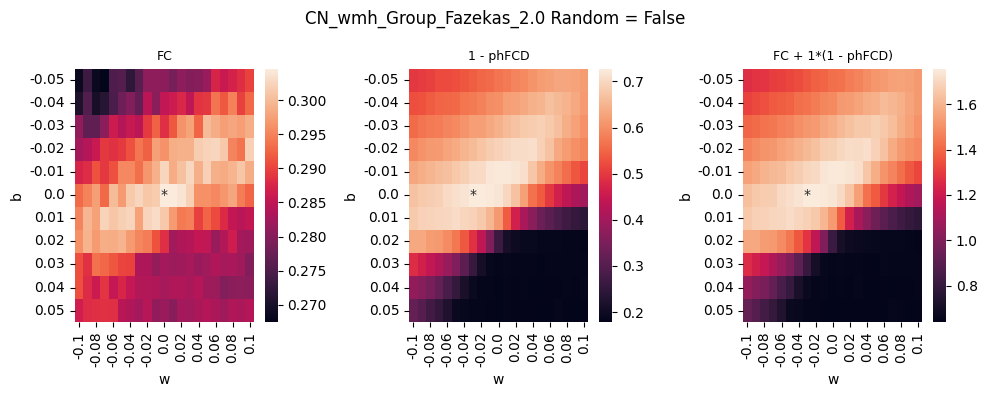

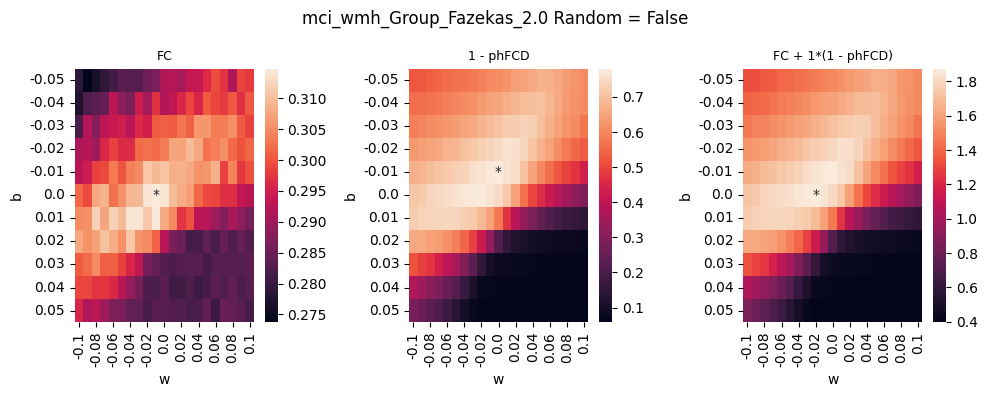

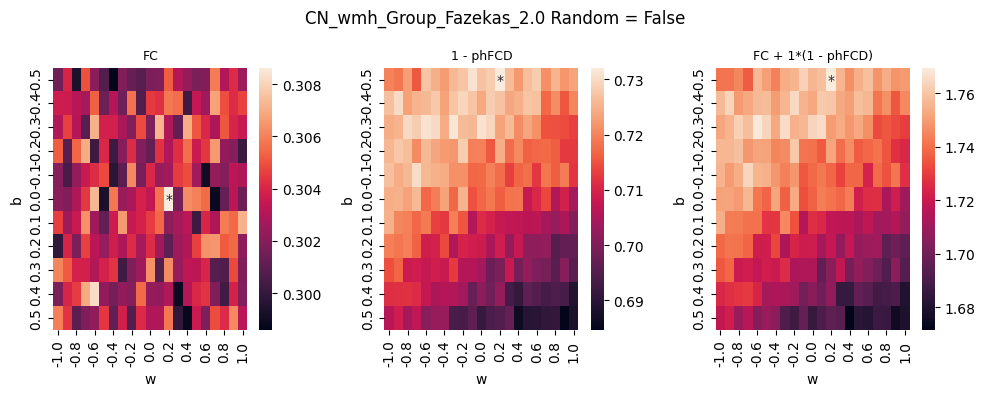

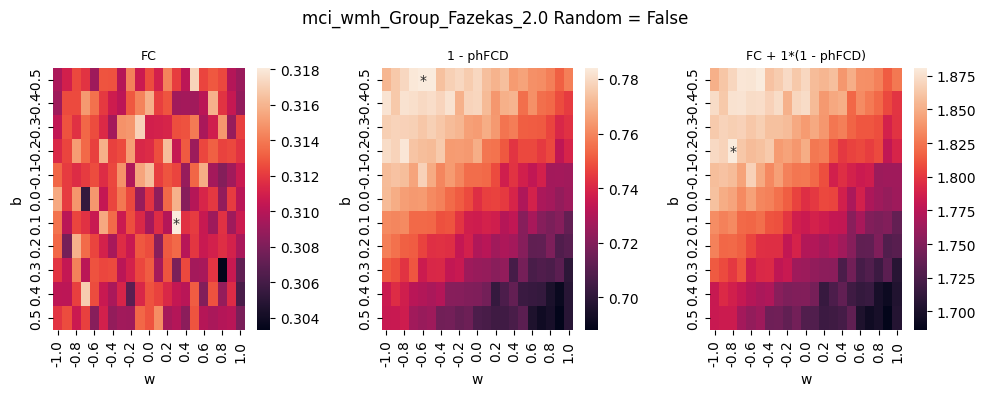

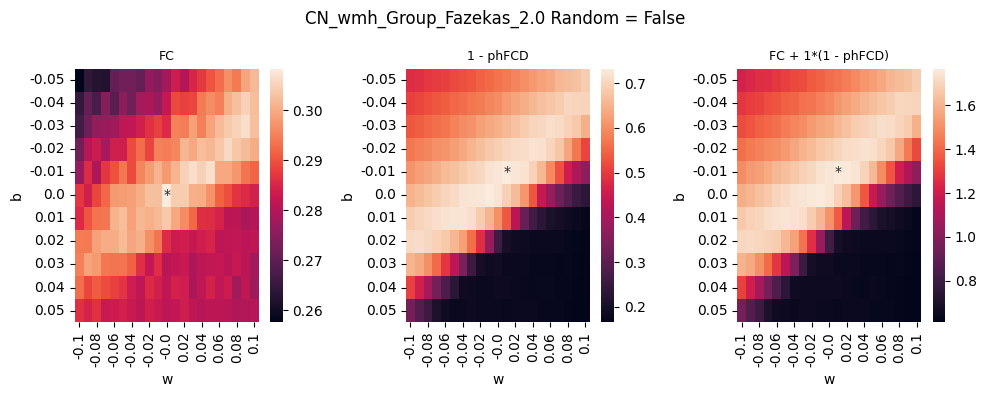

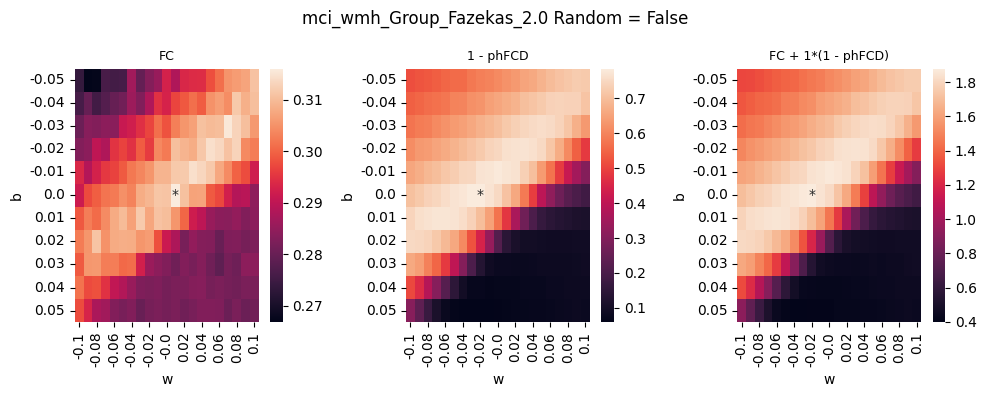

In [7]:
# Find the best b and w for the a-weight, G-weight and heterogeneous models
best_fit_b_CN_a, best_fit_w_CN_a, best_fit_b_mci_a, best_fit_w_mci_a = perform_group_analyses(adnimerge, df_a_big, "Group_Fazekas_2.0", random=False)
best_fit_b_CN_G, best_fit_w_CN_G, best_fit_b_mci_G, best_fit_w_mci_G = perform_group_analyses(adnimerge, df_G_big, "Group_Fazekas_2.0", random=False)
best_fit_b_CN_het, best_fit_w_CN_het, best_fit_b_mci_het, best_fit_w_mci_het = perform_group_analyses(adnimerge, df_het_big, "Group_Fazekas_2.0", False)

In [8]:
# Set the random best to the same value as the non-random best
best_fit_b_CN_a_rand, best_fit_w_CN_a_rand = best_fit_b_CN_a, best_fit_w_CN_a 
best_fit_b_CN_G_rand, best_fit_w_CN_G_rand = best_fit_b_CN_G, best_fit_w_CN_G 
best_fit_b_CN_het_rand, best_fit_w_CN_het_rand = best_fit_b_CN_het, best_fit_w_CN_het


# We create merged databases with clinical information for the remaining models
df_a_big_boxplot = pd.merge(
    df_a_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_a_rand_big_boxplot = pd.merge(
    df_a_rand_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_het_big_boxplot = pd.merge(
    df_het_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_het_rand_big_boxplot = pd.merge(
    df_het_rand_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_G_big_boxplot = pd.merge(
    df_G_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_G_rand_big_boxplot = pd.merge(
    df_G_rand_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_sc_big_boxplot = pd.merge(
df_sc_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

# Create df with only the best values from before for CN
df_boxplot_compare_CN_base = create_df_boxplot(df_a_big_boxplot, 0, 0, "CN_WMH", "Base")
df_boxplot_compare_CN_a = create_df_boxplot(df_a_big_boxplot, best_fit_b_CN_a, best_fit_w_CN_a, "CN_WMH", "Homo.")
df_boxplot_compare_CN_a_rand = create_df_boxplot(df_a_rand_big_boxplot, best_fit_b_CN_a_rand, best_fit_w_CN_a_rand, "CN_WMH", "Homo. rand.")
df_boxplot_compare_CN_het = create_df_boxplot(df_het_big_boxplot, best_fit_b_CN_het, best_fit_w_CN_het, "CN_WMH", "Hetero.")
df_boxplot_compare_CN_het_rand = create_df_boxplot(df_het_rand_big_boxplot, best_fit_b_CN_het_rand, best_fit_w_CN_het_rand, "CN_WMH", "Hetero. rand.")
df_boxplot_compare_CN_G = create_df_boxplot(df_G_big_boxplot, best_fit_b_CN_G, best_fit_w_CN_G, "CN_WMH", "G-weight")
df_boxplot_compare_CN_G_rand = create_df_boxplot(df_G_rand_big_boxplot, best_fit_b_CN_G_rand, best_fit_w_CN_G_rand, "CN_WMH", "G rand.")
df_boxplot_compare_CN_sc = df_sc_big_boxplot[df_sc_big_boxplot["Group_Fazekas_2.0"] == "CN_WMH"].drop(columns = "Group_Fazekas_2.0")
# The structural disconnectivity model doesn't have a weight, so its processing is slightly different
df_boxplot_compare_CN_sc["comp_score"] = df_boxplot_compare_CN_sc["fc_pearson"] + 2*df_boxplot_compare_CN_sc["phfcd_ks"]
df_boxplot_compare_CN_sc["Model_type"] = "Disconn."

df_boxplot_compare_CN = pd.concat([df_boxplot_compare_CN_base, df_boxplot_compare_CN_a, df_boxplot_compare_CN_het, df_boxplot_compare_CN_G, df_boxplot_compare_CN_sc])

In [9]:
# Set the random best to the same value as the non-random best
best_fit_b_mci_a_rand, best_fit_w_mci_a_rand = best_fit_b_mci_a, best_fit_w_mci_a 
best_fit_b_mci_G_rand, best_fit_w_mci_G_rand = best_fit_b_mci_G, best_fit_w_mci_G 
best_fit_b_mci_het_rand, best_fit_w_mci_het_rand = best_fit_b_mci_het, best_fit_w_mci_het

# Perform the same steps done with CN but on MCI
# Create df with only the best values from before for MCI
df_boxplot_compare_mci_base = create_df_boxplot(df_a_big_boxplot, 0, 0, "MCI_WMH", "Base")
df_boxplot_compare_mci_a = create_df_boxplot(df_a_big_boxplot, best_fit_b_mci_a, best_fit_w_mci_a, "MCI_WMH", "Homo.")
df_boxplot_compare_mci_a_rand = create_df_boxplot(df_a_rand_big_boxplot, best_fit_b_mci_a_rand, best_fit_w_mci_a_rand, "MCI_WMH", "Homo. rand.")
df_boxplot_compare_mci_het = create_df_boxplot(df_het_big_boxplot, best_fit_b_mci_het, best_fit_w_mci_het, "MCI_WMH", "Hetero.")
df_boxplot_compare_mci_het_rand = create_df_boxplot(df_het_rand_big_boxplot, best_fit_b_mci_het_rand, best_fit_w_mci_het_rand, "MCI_WMH", "Hetero. rand.")
df_boxplot_compare_mci_G = create_df_boxplot(df_G_big_boxplot, best_fit_b_mci_G, best_fit_w_mci_G, "MCI_WMH", "G-weight")
df_boxplot_compare_mci_G_rand = create_df_boxplot(df_G_rand_big_boxplot, best_fit_b_mci_G_rand, best_fit_w_mci_G_rand, "MCI_WMH", "G rand.")
df_boxplot_compare_mci_sc = df_sc_big_boxplot[df_sc_big_boxplot["Group_Fazekas_2.0"] == "MCI_WMH"].drop(columns = "Group_Fazekas_2.0")
df_boxplot_compare_mci_sc["comp_score"] = df_boxplot_compare_mci_sc["fc_pearson"] + 2*df_boxplot_compare_mci_sc["phfcd_ks"]
df_boxplot_compare_mci_sc["Model_type"] = "Disconn."
df_boxplot_compare_mci = pd.concat([df_boxplot_compare_mci_base, df_boxplot_compare_mci_a, df_boxplot_compare_mci_het, df_boxplot_compare_mci_G, df_boxplot_compare_mci_sc])

In [10]:
# Create a unified long df to compare the model performance between random vs. non-random
df_boxplot_compare_rand_cn = pd.concat([df_boxplot_compare_CN_a, df_boxplot_compare_CN_a_rand, df_boxplot_compare_CN_het, df_boxplot_compare_CN_het_rand, df_boxplot_compare_CN_G, df_boxplot_compare_CN_G_rand])
df_boxplot_compare_rand_cn["Random"] = np.where(df_boxplot_compare_rand_cn['Model_type'].str.contains('rand.'), "Random", "Not Random")
df_boxplot_compare_rand_mci = pd.concat([df_boxplot_compare_mci_a, df_boxplot_compare_mci_a_rand, df_boxplot_compare_mci_het, df_boxplot_compare_mci_het_rand, df_boxplot_compare_mci_G, df_boxplot_compare_mci_G_rand])
df_boxplot_compare_rand_mci["Random"] = np.where(df_boxplot_compare_rand_mci['Model_type'].str.contains('rand.'), "Random", "Not Random")
# Create a unified long df to compare the model performance between groups
df_boxplot_compare_CN["group"] = "CN WMH"
df_boxplot_compare_mci["group"] = "MCI WMH"
df_boxplot_compare = pd.concat([df_boxplot_compare_CN, df_boxplot_compare_mci])

### Prepare dfs with maximum values achieved

In [11]:
# Now let's plot the best FC and 1-phFCDs achievable in the range of explored parameters 
df_base_merged = pd.merge(df_base, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_a_merged = pd.merge(df_max_fc_a, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_a_rand_merged = pd.merge(df_max_fc_a_rand, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_hetero_merged = pd.merge(df_max_fc_hetero, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_G_merged = pd.merge(df_max_fc_G, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_G_rand_merged = pd.merge(df_max_fc_G_rand, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_sc_merged = pd.merge(df_max_fc_sc, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")

df_base_merged["Model_type"] = "Base"

df_max_fc_a_merged["Model_type"] = "Homo."
df_max_fc_a_rand_merged["Model_type"] = "Homo. rand."
df_max_fc_hetero_merged["Model_type"] = "Hetero."
df_max_fc_G_merged["Model_type"] = "G-weight"
df_max_fc_G_rand_merged["Model_type"] = "G rand."
df_max_fc_sc_merged["Model_type"] = "Disconn."

df_max_phfcd_a_merged = pd.merge(df_max_phfcd_a, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_a_rand_merged = pd.merge(df_max_phfcd_a_rand, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_sc_merged = pd.merge(df_max_phfcd_sc, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_G_merged = pd.merge(df_max_phfcd_G, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_G_rand_merged = pd.merge(df_max_phfcd_G_rand, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_hetero_merged = pd.merge(df_max_phfcd_hetero, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")

df_max_phfcd_a_merged["Model_type"] = "Homo."
df_max_phfcd_a_rand_merged["Model_type"] = "Homo. rand."
df_max_phfcd_hetero_merged["Model_type"] = "Hetero."
df_max_phfcd_G_merged["Model_type"] = "G-weight"
df_max_phfcd_G_rand_merged["Model_type"] = "G rand."
df_max_phfcd_sc_merged["Model_type"] = "Disconn."

In [12]:
# Select only CN
df_base_merged_CN = df_base_merged[df_base_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_a_merged_CN = df_max_fc_a_merged[df_max_fc_a_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_a_rand_merged_CN = df_max_fc_a_rand_merged[df_max_fc_a_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_hetero_merged_CN = df_max_fc_hetero_merged[df_max_fc_hetero_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_G_merged_CN = df_max_fc_G_merged[df_max_fc_G_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_G_rand_merged_CN = df_max_fc_G_rand_merged[df_max_fc_G_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_sc_merged_CN = df_max_fc_sc_merged[df_max_fc_sc_merged["Group_Fazekas_2.0"] == "CN_WMH"]

df_max_phfcd_a_merged_CN = df_max_phfcd_a_merged[df_max_phfcd_a_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_a_rand_merged_CN = df_max_phfcd_a_rand_merged[df_max_phfcd_a_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_hetero_merged_CN = df_max_phfcd_hetero_merged[df_max_phfcd_hetero_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_hetero_merged_CN = df_max_phfcd_hetero_merged_CN.dropna()
df_max_phfcd_G_merged_CN = df_max_phfcd_G_merged[df_max_phfcd_G_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_G_rand_merged_CN = df_max_phfcd_G_rand_merged[df_max_phfcd_G_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_sc_merged_CN = df_max_phfcd_sc_merged[df_max_phfcd_sc_merged["Group_Fazekas_2.0"] == "CN_WMH"]

df_max_fc_CN = pd.concat([df_base_merged_CN, df_max_fc_a_merged_CN, df_max_fc_hetero_merged_CN, df_max_fc_G_merged_CN, df_max_fc_sc_merged_CN])
df_max_phfcd_CN = pd.concat([df_base_merged_CN, df_max_phfcd_a_merged_CN, df_max_phfcd_hetero_merged_CN, df_max_phfcd_G_merged_CN, df_max_phfcd_sc_merged_CN])

In [13]:
# Select only MCI
df_base_merged_mci = df_base_merged[df_base_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_a_merged_mci = df_max_fc_a_merged[df_max_fc_a_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_a_rand_merged_mci = df_max_fc_a_rand_merged[df_max_fc_a_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_hetero_merged_mci = df_max_fc_hetero_merged[df_max_fc_hetero_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_G_merged_mci = df_max_fc_G_merged[df_max_fc_G_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_G_rand_merged_mci = df_max_fc_G_rand_merged[df_max_fc_G_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_sc_merged_mci = df_max_fc_sc_merged[df_max_fc_sc_merged["Group_Fazekas_2.0"] == "MCI_WMH"]

df_max_phfcd_a_merged_mci = df_max_phfcd_a_merged[df_max_phfcd_a_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_a_rand_merged_mci = df_max_phfcd_a_rand_merged[df_max_phfcd_a_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
# This dataset contain multiple values for one pts, so we filter them out..
df_max_phfcd_a_rand_merged_mci = df_max_phfcd_a_rand_merged_mci.drop_duplicates(["PTID"])
df_max_phfcd_hetero_merged_mci = df_max_phfcd_hetero_merged[df_max_phfcd_hetero_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_G_merged_mci = df_max_phfcd_G_merged[df_max_phfcd_G_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_G_rand_merged_mci = df_max_phfcd_G_rand_merged[df_max_phfcd_G_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_sc_merged_mci = df_max_phfcd_sc_merged[df_max_phfcd_sc_merged["Group_Fazekas_2.0"] == "MCI_WMH"]

df_max_fc_mci = pd.concat([df_base_merged_mci, df_max_fc_a_merged_mci, df_max_fc_hetero_merged_mci, df_max_fc_G_merged_mci, df_max_fc_sc_merged_mci])
df_max_phfcd_mci = pd.concat([df_base_merged_mci, df_max_phfcd_a_merged_mci, df_max_phfcd_hetero_merged_mci, df_max_phfcd_G_merged_mci, df_max_phfcd_sc_merged_mci])

Now we ask ourselves, what are the values of a (obtained from the given combination of best w and best b) that give the best results? 

## Analyses

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:5.267e-01 Stat=1.270e+03
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:3.282e-01 Stat=1.206e+03
Base vs. G-weight: Wilcoxon test (paired samples), P_val:8.483e-01 Stat=1.352e+03
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:2.868e-10 Stat=2.170e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:3.229e-01 Stat=1.204e+03
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:1.349e-01 Stat=1.110e+03
Base vs. G-weight: Wilcoxon test (paired samples), P_val:8.718e-02 Stat=1.070e+03
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:1.429e-05 Stat=

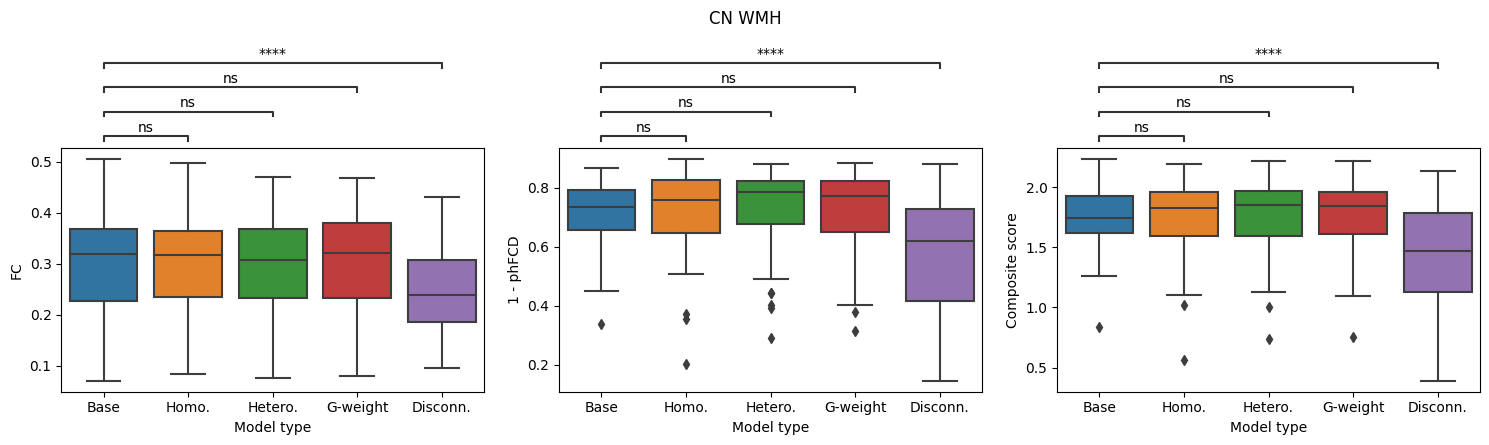

In [14]:
# Plot the boxplot
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
plot_obs(df_boxplot_compare_CN, "fc_pearson")
plt.ylabel("FC")
plt.subplot(132)
plot_obs(df_boxplot_compare_CN, "phfcd_ks")
plt.ylabel("1 - phFCD")
plt.subplot(133)
plot_obs(df_boxplot_compare_CN, "comp_score")
plt.ylabel("Composite score")
fig.suptitle("CN WMH", y = 0.88)
fig.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hetero._Random vs. Hetero._Not Random: Wilcoxon test (paired samples), P_val:7.526e-01 Stat=1.329e+03
Homo._Random vs. Homo._Not Random: Wilcoxon test (paired samples), P_val:1.843e-02 Stat=9.500e+02
G-weight_Random vs. G-weight_Not Random: Wilcoxon test (paired samples), P_val:2.479e-01 Stat=1.173e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hetero._Random vs. Hetero._Not Random: Wilcoxon test (paired samples), P_val:1.637e-01 Stat=1.129e+03
Homo._Random vs. Homo._Not Random: Wilcoxon test (paired samples), P_val:1.412e-04 Stat=6.810e+02
G-weight_Random vs. G-weight_Not Random: Wilcoxon test (paired samples), P_val:8.907e-01 Stat=1.362e+03
p-value annotation legend:
   

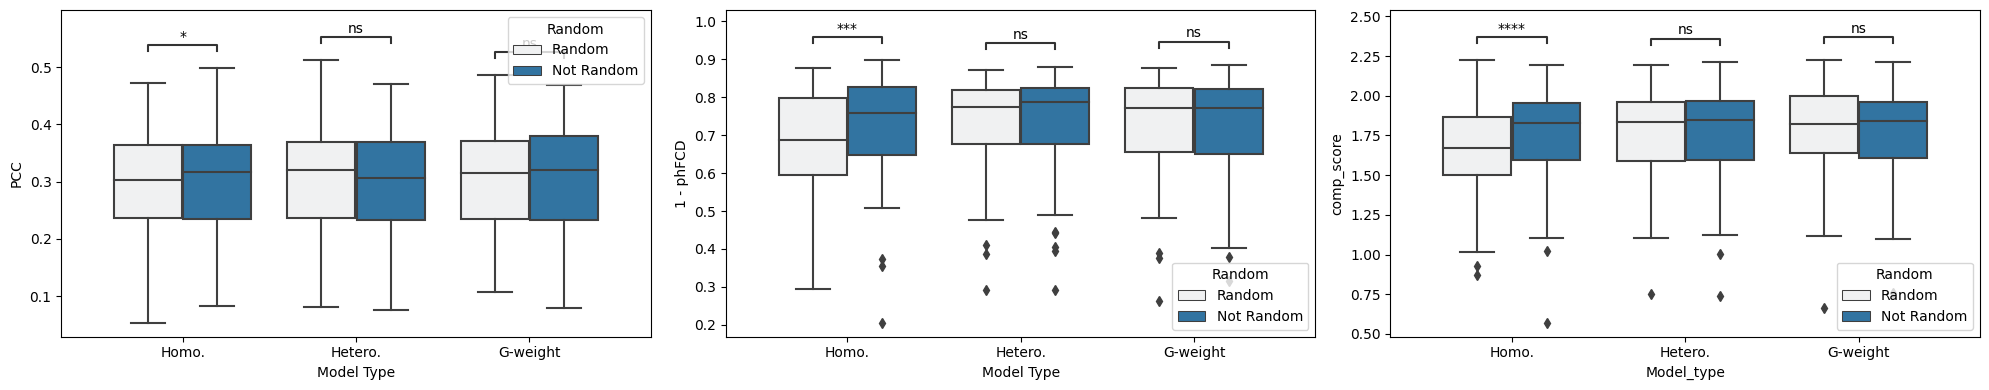

In [15]:
# Plot the model performance between groups
fig, axs = plt.subplots(nrows= 1, ncols = 3, figsize = (20, 4))
plot_random_comparison(df_boxplot_compare_rand_cn, 'fc_pearson', axs[0])
axs[0].set_ylabel("PCC")
axs[0].set_xlabel("Model Type")
plot_random_comparison(df_boxplot_compare_rand_cn, 'phfcd_ks', axs[1])
axs[1].set_ylabel("1 - phFCD")
axs[1].set_xlabel("Model Type")
plot_random_comparison(df_boxplot_compare_rand_cn, 'comp_score', axs[2])
fig.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:7.941e-01 Stat=7.660e+02
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:8.376e-02 Stat=5.860e+02
Base vs. G-weight: Wilcoxon test (paired samples), P_val:5.903e-01 Stat=7.320e+02
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:4.493e-09 Stat=7.900e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:2.103e-03 Stat=4.210e+02
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:1.068e-04 Stat=3.230e+02
Base vs. G-weight: Wilcoxon test (paired samples), P_val:7.880e-05 Stat=3.140e+02
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:8.492e-04 Stat=

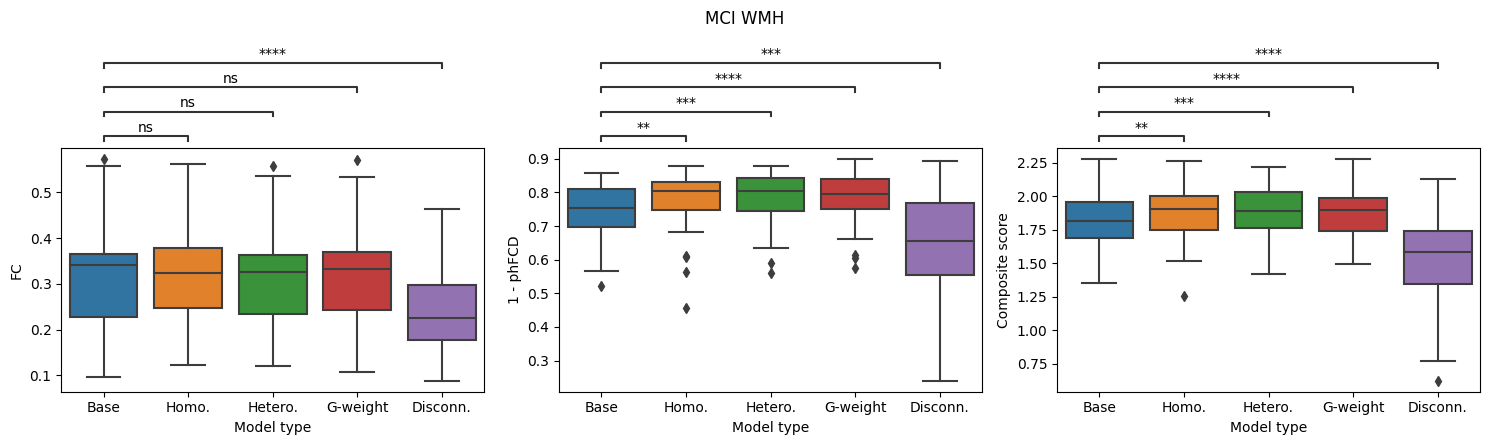

In [25]:
# Plot the boxplot
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
plot_obs(df_boxplot_compare_mci, "fc_pearson")
plt.ylabel("FC")
plt.subplot(132)
plot_obs(df_boxplot_compare_mci, "phfcd_ks")
plt.ylabel("1 - phFCD")
plt.subplot(133)
plot_obs(df_boxplot_compare_mci, "comp_score")
plt.ylabel("Composite score")
fig.suptitle("MCI WMH", y = 0.88)
fig.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hetero._Random vs. Hetero._Not Random: Wilcoxon test (paired samples), P_val:3.118e-01 Stat=6.740e+02
Homo._Random vs. Homo._Not Random: Wilcoxon test (paired samples), P_val:8.671e-02 Stat=5.880e+02
G-weight_Random vs. G-weight_Not Random: Wilcoxon test (paired samples), P_val:3.118e-01 Stat=6.740e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hetero._Random vs. Hetero._Not Random: Wilcoxon test (paired samples), P_val:5.735e-01 Stat=7.290e+02
Homo._Random vs. Homo._Not Random: Wilcoxon test (paired samples), P_val:7.548e-04 Stat=3.850e+02
G-weight_Random vs. G-weight_Not Random: Wilcoxon test (paired samples), P_val:1.881e-02 Stat=5.100e+02
p-value annotation legend:
   

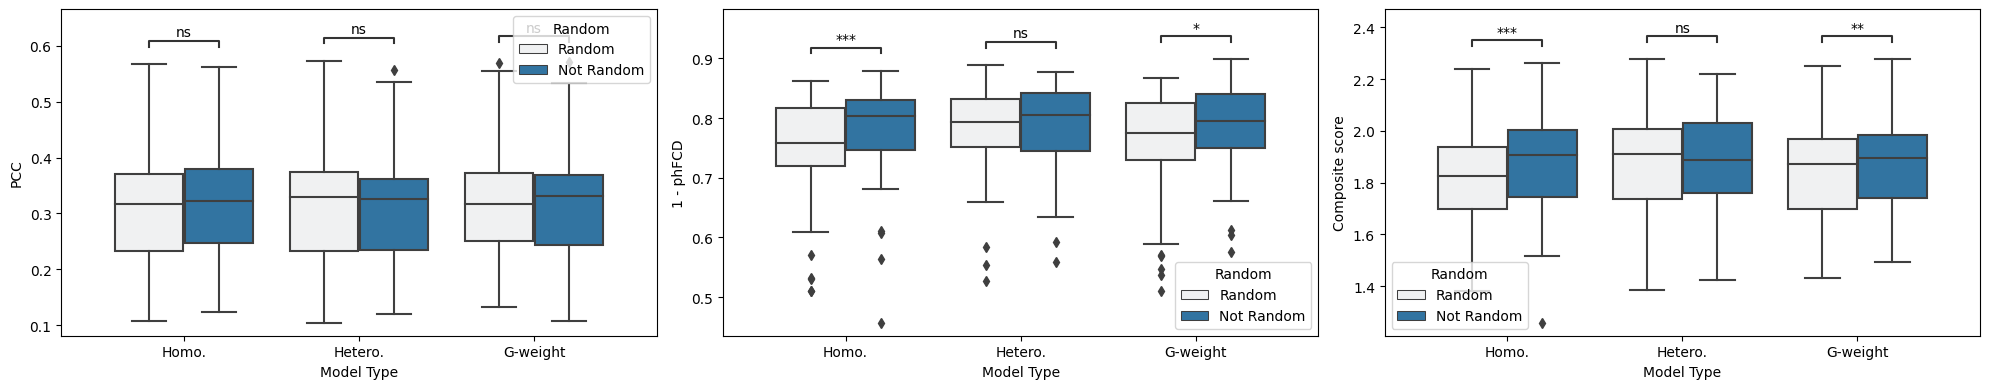

In [17]:
# Plot the model performance between groups
fig, axs = plt.subplots(nrows= 1, ncols = 3, figsize = (20, 4))
plot_random_comparison(df_boxplot_compare_rand_mci, 'fc_pearson', axs[0])
axs[0].set_ylabel("PCC")
axs[0].set_xlabel("Model Type")
plot_random_comparison(df_boxplot_compare_rand_mci, 'phfcd_ks', axs[1])
axs[1].set_ylabel("1 - phFCD")
axs[1].set_xlabel("Model Type")
plot_random_comparison(df_boxplot_compare_rand_mci, 'comp_score', axs[2])
axs[2].set_ylabel("Composite score")
axs[2].set_xlabel("Model Type")
fig.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Homo._CN WMH vs. Homo._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:5.839e-01 U_stat=1.955e+03
Base_CN WMH vs. Base_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:7.121e-01 U_stat=1.993e+03
Hetero._CN WMH vs. Hetero._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:8.897e-01 U_stat=2.042e+03
G-weight_CN WMH vs. G-weight_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:7.581e-01 U_stat=2.006e+03
Disconn._CN WMH vs. Disconn._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:6.773e-01 U_stat=2.161e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Homo._CN WMH vs. Homo._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.111e-02 U_stat=1.613e+03
Base_C

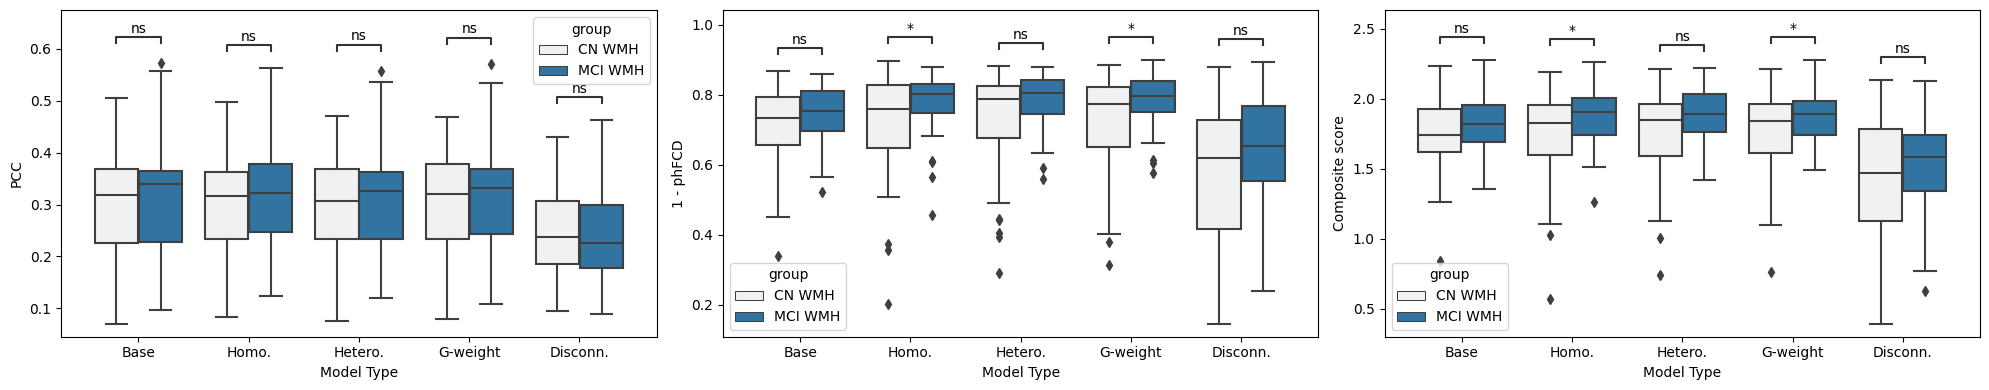

In [18]:
# Plot the model performance between random conditions
fig, axs = plt.subplots(nrows= 1, ncols = 3, figsize = (20, 4))
plot_CN_mci_comparison('fc_pearson', axs[0])
axs[0].set_ylabel("PCC")
axs[0].set_xlabel("Model Type")
plot_CN_mci_comparison('phfcd_ks', axs[1])
axs[1].set_ylabel("1 - phFCD")
axs[1].set_xlabel("Model Type")
plot_CN_mci_comparison('comp_score', axs[2])
axs[2].set_ylabel("Composite score")
axs[2].set_xlabel("Model Type")
fig.tight_layout()

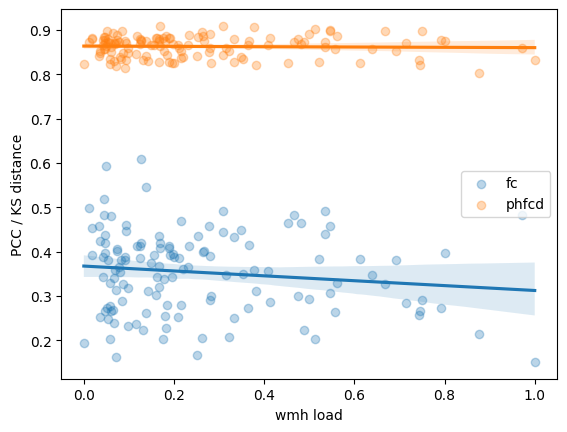

In [19]:
# Plot relationship between best overall model fits in this simulation and wmh load
# Here, all together, with regression
plt.figure()
ax1 = sns.regplot(
    data=df_max_fc_a,
    y="fc_pearson",
    x="wmh_load",
    order=1,
    scatter_kws={"alpha": 0.3},
    label="fc",
)
# ax2 = sns.regplot(res_df_best, y = 'fcd_ks', x = 'wmh_load', order = 2, scatter_kws={'alpha':0.3}, label = 'fcd')
ax3 = sns.regplot(
    data=df_max_phfcd_a,
    y="phfcd_ks",
    x="wmh_load",
    order=1,
    scatter_kws={"alpha": 0.3},
    label="phfcd",
)
ax3.set(ylabel="PCC / KS distance", xlabel="wmh load")
plt.legend()
plt.show()
plt.savefig(FIG_DIR / "summary_best_values_regression.png")
plt.close()

In [20]:
# Calculate the best a from the best w and the best b
df_max_fc_a["a"] = -0.02 + df_max_fc_a["w"] * df_max_fc_a["wmh_load"] + df_max_fc_a["b"]
df_max_phfcd_a["a"] = (
    -0.02 + df_max_phfcd_a["w"] * df_max_phfcd_a["wmh_load"] + df_max_phfcd_a["b"]
)

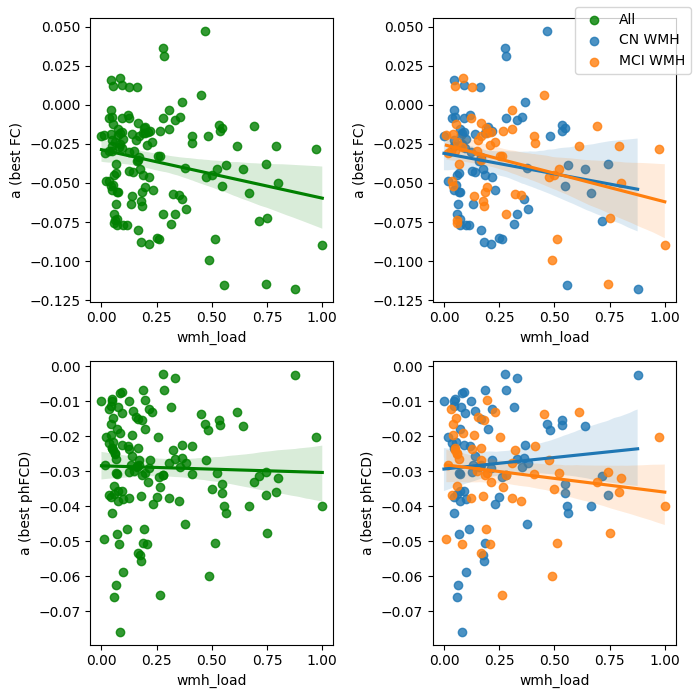

In [21]:
# Plot the relationship with the a
plot_parm_best_wmh_relationship("a")
# Plot the relationship with the b
# plot_parm_best_wmh_relationship("b")
# Plot the relationship with the w
# plot_parm_best_wmh_relationship("w")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:7.733e-14 Stat=0.000e+00
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:7.733e-14 Stat=0.000e+00
Base vs. G-weight: Wilcoxon test (paired samples), P_val:7.733e-14 Stat=0.000e+00
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:2.868e-10 Stat=2.170e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:7.733e-14 Stat=0.000e+00
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:7.733e-14 Stat=0.000e+00
Base vs. G-weight: Wilcoxon test (paired samples), P_val:9.107e-14 Stat=4.000e+00
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:2.920e-11 Stat=

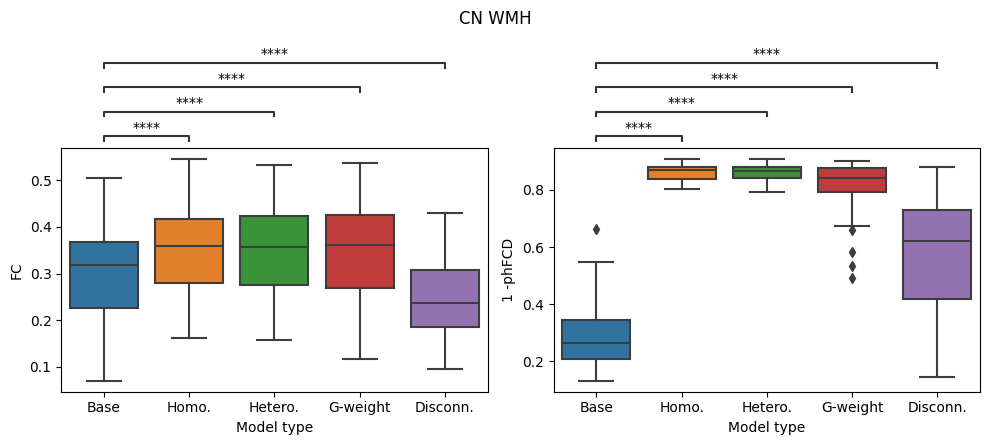

In [22]:
# It doesn't make sense to create a composite score, because we have that the value that gives the best FC is not the same that gives the best phFCD...
# Plot the boxplot
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
plot_obs(df_max_fc_CN, "fc_pearson")
plt.ylabel("FC")
plt.subplot(122)
plot_obs(df_max_phfcd_CN, "phfcd_ks")
plt.ylabel("1 -phFCD")
fig.suptitle("CN WMH", y = 0.88)
fig.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:1.108e-10 Stat=0.000e+00
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:7.547e-11 Stat=0.000e+00
Base vs. G-weight: Wilcoxon test (paired samples), P_val:7.547e-11 Stat=0.000e+00
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:4.493e-09 Stat=7.900e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homo.: Wilcoxon test (paired samples), P_val:7.547e-11 Stat=0.000e+00
Base vs. Hetero.: Wilcoxon test (paired samples), P_val:7.547e-11 Stat=0.000e+00
Base vs. G-weight: Wilcoxon test (paired samples), P_val:7.547e-11 Stat=0.000e+00
Base vs. Disconn.: Wilcoxon test (paired samples), P_val:8.880e-11 Stat=

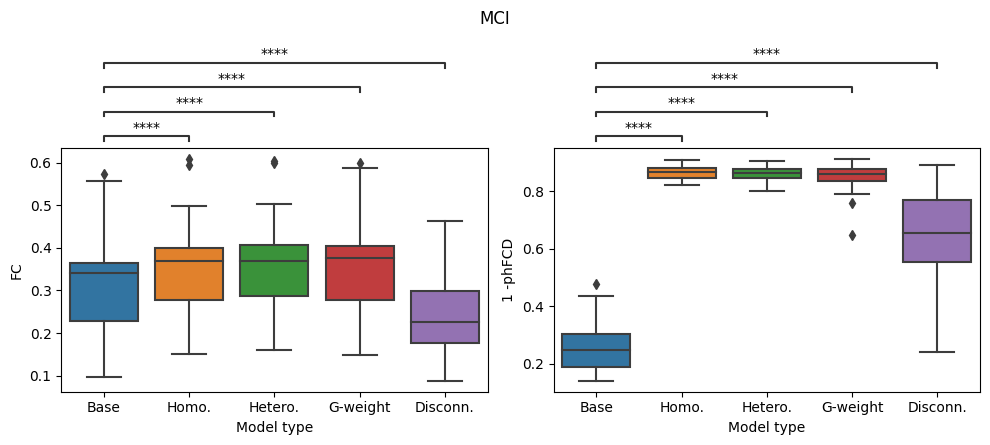

In [23]:
# It doesn't make sense to create a composite score, because we have that the value that gives the best FC is not the same that gives the best phFCD...
# Plot the boxplot
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
plot_obs(df_max_fc_mci, "fc_pearson")
plt.ylabel("FC")
plt.subplot(122)
plot_obs(df_max_phfcd_mci, "phfcd_ks")
plt.ylabel("1 -phFCD")
fig.suptitle("MCI", y = 0.88)
fig.tight_layout()